# Deep Learning course - LAB 7

## ConvNets 101

### Recap from previous Lab

* we introduced some basic image processing functionalities with OpenCV
* we saw how to import a custom dataset in PyTorch, how to operate data augmentation, and how to create a DataLoader out of it

### Agenda for today

* we will construct our first Convolutional Neural Network (CNN)
* we will show how to do transfer learning on CNNs
* we will show how to introduce Deconvolution/Inverse Convolution inside CNNs
* we will construct our own implementation of two famous CNN architectures: ResNet and U-Net

## Our first CNN

Building CNNs is actually not hard once you know all the pieces to construct a MultiLayer Perceptron.

We can distinguish between two macro-categories of CNNs, at least for the part concerning image classification. We might call them "historical" and "modern", although characteristics of both can sometimes get pretty much mixed-up.

* "Historical" CNNs are a stack composed of two parts:
  * a **convolutional** part, where have a cascade of convolutional layers intertwined with pooling layers for dimensionality and complexity reduction
    * usually the filters in each convolutional layer are more numerous as the image size shrinks (i.e., as we get further from the input)
  * a **fully-connected** part, where we have a sequence of few fully-connected layer, ending up in the output layer, where, as usual, we have as many neurons as there are categories
  
 the epitome of the historical CNN (which is still used in research today nonetheless) is VGGNet (or simply VGG). Its *core* is a **convolutional block** composed of two or three convolutional layers each with the same number of filters, which is double the number of filters of the previous layer, up to 512 filters per layer. At the end of each block, there's a Max Pooling layer which halves the spatial dimension of the image.

 In the picture below, you can see a modern implementation of VGG with only one fully-connected layer.
  ![](img/vgg.png)
  


* "Modern" CNNs, instead, get rid of the fully-connected part, as usually
    1. it introduces a considerable amount of parameters in the network (note that the convolutional layers, due to their local connectivity and shared weights, have a much lower number of parameters w.r.t. fully connected layers)
    2. it keeps the 2D spatial structure of the image intact up to the last hidden layer, allowing for more interpretal parameters/neurons (*insert Olah citation here*)
    3. it represents a "rigid" portion of the network in the sense that it constrains they size of the image to be fixed. We will see later how this can pose a problem.

 Sometimes, even the pooling layers may get replaced by convolutional layers with large kernel size, as its effect is to reduce dimensionality (i.e., height and width) of the corresponding image.
 
 Recently, the **residual block** has become one of the paramount structures in modern CNNs. It forces the network to learn image features by actually learning to *reconstruct itself* (sometimes in lower spatial dimensionality) rather than learn immediately features for the classification task. In the image below, you can see how a **residual network (resnet)** can be structured:

 ![](img/resnet.png)

 The 2 residual blocks are composed of two convolutional layers, after which the input of the first layer bypasses the whole two layers and gets summed to the output of the second layer. This bypass is called **skip connection**.

In [83]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torchvision.models import vgg16_bn
from torchsummary import summary
from scripts import mnistm
from scripts import mnist
from scripts import train
from matplotlib import pyplot as plt

In [2]:
class CNN(nn.Module):
    def _build_vgg_block(self, num_conv_layers, in_channels, out_channels, kernel_size=3, batchnorm=True, activation=nn.ReLU, maxpool=True):
        layers = []
        for i in range(num_conv_layers):
            if i == 0:
                num_channels_in = in_channels
            else:
                num_channels_in = out_channels
            
            layers.append(nn.Conv2d(in_channels=num_channels_in, out_channels=out_channels, kernel_size=kernel_size))
            if batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation())
        
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=2))
        return nn.Sequential(*layers)

    def __init__(self, num_classes=10, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            self._build_vgg_block(2, in_channels, 16, activation=nn.SiLU),
            self._build_vgg_block(2, 16, 32, activation=nn.SiLU)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, num_classes)
        )

    def forward(self, X):
        return self.classifier(self.avgpool(self.features(X)))

In [3]:
net = CNN(in_channels=3)
_ = summary(net)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  448
|    |    └─BatchNorm2d: 3-2             32
|    |    └─SiLU: 3-3                    --
|    |    └─Conv2d: 3-4                  2,320
|    |    └─BatchNorm2d: 3-5             32
|    |    └─SiLU: 3-6                    --
|    |    └─MaxPool2d: 3-7               --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-8                  4,640
|    |    └─BatchNorm2d: 3-9             64
|    |    └─SiLU: 3-10                   --
|    |    └─Conv2d: 3-11                 9,248
|    |    └─BatchNorm2d: 3-12            64
|    |    └─SiLU: 3-13                   --
|    |    └─MaxPool2d: 3-14              --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Flatten: 2-3                      --
|    └─Linear: 2-4                       330
Total params: 17

Test if the net works on random data

In [39]:
X = torch.rand((100,3,28,28))
y = net(X)
y.shape

torch.Size([100, 10])

Let's go more in detail in the computation

In [40]:
z = X
print("in", z.shape)
for i, mod in enumerate(net.features):
    z = mod(z)
    print(i, z.shape)

z = net.avgpool(z)
print("avgpool", z.shape)

z = net.classifier(z)
print("out", z.shape)

in torch.Size([100, 3, 28, 28])
0 torch.Size([100, 16, 12, 12])
1 torch.Size([100, 32, 4, 4])
avgpool torch.Size([100, 32, 1, 1])
out torch.Size([100, 10])


In [4]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize([0.4639, 0.4676, 0.4199], [0.2534, 0.2380, 0.2618]), # I pre-computed these data
])

mnistm_train = mnistm.MNISTM(root="datasets/MNISTM", download=True, transform=transforms)
mnistm_test = mnistm.MNISTM(root="datasets/MNISTM", train=False, download=True, transform=transforms)

Ground truth: 5


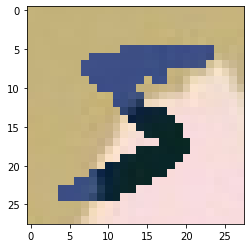

In [42]:
img = (mnistm_train.train_data[0].numpy() * 255).astype("uint8")
plt.imshow(img)
print("Ground truth:", mnistm_train.train_labels[0].item())

In [43]:
mnistm_test.test_data.shape, mnistm_test.test_labels.shape

(torch.Size([10000, 28, 28, 3]), torch.Size([10000]))

In [5]:
batch_train = 128
batch_test = 512
mnistm_trainloader = DataLoader(mnistm_train, batch_train, shuffle=True, num_workers=8)
mnistm_testloader = DataLoader(mnistm_test, batch_test, shuffle=False, num_workers=8)

In [60]:
optim = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=5e-4, momentum=.9)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=12)

In [61]:
train.train_model(net, mnistm_trainloader, loss_fn=nn.CrossEntropyLoss(), optimizer=optim, num_epochs=50, lr_scheduler=scheduler)

Epoch 1 --- learning rate 0.10000
Epoch 1 completed. Loss - total: 39916.70584964752 - average: 0.6652784308274587; Performance: 0.7851166666666667
Epoch 2 --- learning rate 0.10000
Epoch 2 completed. Loss - total: 14302.629755973816 - average: 0.2383771625995636; Performance: 0.92725
Epoch 3 --- learning rate 0.10000
Epoch 3 completed. Loss - total: 11274.251604557037 - average: 0.18790419340928396; Performance: 0.9429
Epoch 4 --- learning rate 0.10000
Epoch 4 completed. Loss - total: 10188.28065109253 - average: 0.16980467751820882; Performance: 0.9482
Epoch 5 --- learning rate 0.10000
Epoch 5 completed. Loss - total: 9535.263808250427 - average: 0.15892106347084045; Performance: 0.9522666666666667
Epoch 6 --- learning rate 0.10000
Epoch 6 completed. Loss - total: 9109.877534151077 - average: 0.1518312922358513; Performance: 0.9540666666666666
Epoch 7 --- learning rate 0.10000
Epoch 7 completed. Loss - total: 8784.52181816101 - average: 0.1464086969693502; Performance: 0.956216666666

(2851.5374298095703, 0.9902833333333333)

In [64]:
torch.save(net.state_dict(), "models_push/cnn_mnistm/model.pt")

In [7]:
net.load_state_dict(torch.load("models_push/cnn_mnistm/model.pt"))

<All keys matched successfully>

In [8]:
train.test_model(net, mnistm_testloader)

TESTING - loss -- - performance 0.979


(None, 0.979)

### Transfer Learning

Transfer Learning (TL) is the utilization of a model, built for a given task (**upstream task**) on one or more different tasks (**downstream task**).

We might find oursevles in different situations:

1. we might just re-use the model for the upstream task without re-training
2. we might want to re-train the model on the downstream task (with some constraints)
3. we might want to fully re-train the model, using the `state_dict` from the upstream task as an **initialization** for the training on the downstream task

Note that these options are possible only if the upstream task and the downstream tasks are in a way *relatable* (the number of classes is the same).

Also, in some configurations there may be issues when the images of the upstream task have a different size than those of the downstream task.

In these cases, I need to **re-adapt the network** by modifying neurons in the output layer or by toggling the number of incoming units in given layers.

#### Re-use the same model on MNIST

Basically, we wish to do this:

![](img/tl1.jpg)

We just need to import MNIST.

In [52]:
_, _, mnist_train, mnist_test = mnist.get_data()
mnist_train.data.shape

torch.Size([60000, 28, 28])

Have a look at the shape.

**Q**: What do we need to do?


In [53]:
class MNIST_3(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset, transform=None):
        n, h, w = mnist_dataset.data.shape
        self.data = mnist_dataset.data.clone().unsqueeze(1).expand(n, 3, h, w)
        self.targets = mnist_dataset.targets.clone()
        if transform is None:
            self.transform = lambda x: x
        else:
            self.transform = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.transform(self.data[index]), self.targets[index]

In [54]:
transforms_mnist = T.Compose([
    lambda x: x/255,
    T.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
])
mnist3_train = MNIST_3(mnist_train, transforms_mnist)
mnist3_test = MNIST_3(mnist_test, transforms_mnist)

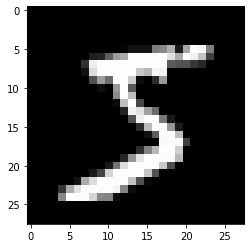

In [74]:
plt.imshow(mnist3_train.data[0].permute(1,2,0))

In [71]:
mnist_trainloader = DataLoader(mnist3_train, 512, shuffle=False, num_workers=0)
mnist_testloader = DataLoader(mnist3_test, 512, shuffle=False, num_workers=0)

In [72]:
train.test_model(net, mnist_trainloader)
train.test_model(net, mnist_testloader)

TESTING - loss -- - performance 0.8295833333333333
TESTING - loss -- - performance 0.8285


(None, 0.8285)

In [77]:
transform_cifar = T.Compose([T.ToTensor(), T.Normalize([0.4913997551666284, 0.48215855929893703, 0.4465309133731618], [0.24703225141799082, 0.24348516474564, 0.26158783926049628])])

cifar_train = CIFAR10("datasets/CIFAR", train=True, transform=transform_cifar, download=True)
cifar_test = CIFAR10("datasets/CIFAR", train=False, transform=transform_cifar, download=True)

Using downloaded and verified file: datasets/CIFAR/cifar-10-python.tar.gz
Extracting datasets/CIFAR/cifar-10-python.tar.gz to datasets/CIFAR
Files already downloaded and verified


In [90]:
cifar_trainloader = DataLoader(cifar_train, batch_size=128, shuffle=True)
cifar_testloader = DataLoader(cifar_test, batch_size=512, shuffle=True)

In [81]:
print("Shape of trainset", cifar_train.data.shape)
print("Num classes", max(cifar_test.targets) + 1)

Shape of trainset (50000, 32, 32, 3)
Num classes 10


In [89]:
vgg = vgg16_bn(pretrained=True)
vgg.classifier[-1].out_features = 10

In [91]:
train.test_model(vgg, cifar_testloader)

TESTING - loss -- - performance 0.0003


(None, 0.0003)

In [96]:
# freeze training in almost all layers
for name, param in vgg.named_parameters():
    if "classifier.6" not in name:
        param.requires_grad = False

In [97]:
for name, param in vgg.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.1.weight False
features.1.bias False
features.3.weight False
features.3.bias False
features.4.weight False
features.4.bias False
features.7.weight False
features.7.bias False
features.8.weight False
features.8.bias False
features.10.weight False
features.10.bias False
features.11.weight False
features.11.bias False
features.14.weight False
features.14.bias False
features.15.weight False
features.15.bias False
features.17.weight False
features.17.bias False
features.18.weight False
features.18.bias False
features.20.weight False
features.20.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.25.weight False
features.25.bias False
features.27.weight False
features.27.bias False
features.28.weight False
features.28.bias False
features.30.weight False
features.30.bias False
features.31.weight False
features.31.bias False
features.34.weight False
features.34.bias False
feat

In [99]:
optimizer = torch.optim.Adam(vgg.parameters())
train.train_model(vgg, cifar_trainloader, nn.CrossEntropyLoss(), optimizer, 20)

Epoch 1 --- learning rate 0.00100
Epoch 1 completed. Loss - total: 104514.88572311401 - average: 2.09029771446228; Performance: 0.39444
Epoch 2 --- learning rate 0.00100
Epoch 2 completed. Loss - total: 82215.03775596619 - average: 1.6443007551193238; Performance: 0.45688
Epoch 3 --- learning rate 0.00100
Epoch 3 completed. Loss - total: 82082.87772369385 - average: 1.641657554473877; Performance: 0.45366
Epoch 4 --- learning rate 0.00100
Epoch 4 completed. Loss - total: 82183.42641067505 - average: 1.643668528213501; Performance: 0.46088
Epoch 5 --- learning rate 0.00100
Epoch 5 completed. Loss - total: 82216.7146434784 - average: 1.644334292869568; Performance: 0.4589
Epoch 6 --- learning rate 0.00100
Epoch 6 completed. Loss - total: 82022.21513366699 - average: 1.6404443026733397; Performance: 0.46338
Epoch 7 --- learning rate 0.00100
Epoch 7 completed. Loss - total: 83208.70336914062 - average: 1.6641740673828125; Performance: 0.45666
Epoch 8 --- learning rate 0.00100
Epoch 8 compl

(82190.5898475647, 0.46264)